# Cargar el dataset

In [8]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Cargar dataset
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('/content/camas_clima.csv')
df.head()

Saving camas_clima.csv to camas_clima (1).csv


,provincia,fecha,tmax,tmin,precip_mm,humedad_%,viento_kph,hospital,camas_iniciales_planta,camas_habilitadas_planta,camas_ocupadas_planta,camas_iniciales_uci,camas_habilitadas_uci,camas_ocupadas_uci,camas_ocupadas_covid_uci,codigo_ine
0,Burgos,2022-01-01,15,4,0.0,54,11,Complejo Asistencial Universitario de Burgos,842.0,755.0,457.0,42.0,47.0,38.0,13.0,9059
1,Burgos,2022-01-01,15,4,0.0,54,11,Hospital Santiago ApÃ³stol,114.0,109.0,33.0,0.0,0.0,0.0,0.0,9059
2,Burgos,2022-01-01,15,4,0.0,54,11,Hospital Santos Reyes,114.0,114.0,53.0,0.0,0.0,0.0,0.0,9059
3,Burgos,2022-01-02,13,6,0.0,63,13,Hospital Santiago ApÃ³stol,114.0,106.0,45.0,0.0,0.0,0.0,0.0,9059
4,Burgos,2022-01-02,13,6,0.0,63,13,Complejo Asistencial Universitario de Burgos,842.0,758.0,478.0,42.0,47.0,39.0,14.0,9059


## Preprocesar columnas

In [12]:
import pandas as pd

# Convertir fecha
df["fecha"] = pd.to_datetime(df["fecha"])

# Crear el target total
df["camas_ocupadas_total"] = df["camas_ocupadas_planta"] + df["camas_ocupadas_uci"]

# Revisar columnas clave
print(df.columns)


Index(['provincia', 'fecha', 'tmax', 'tmin', 'precip_mm', 'humedad_%',
       'viento_kph', 'hospital', 'camas_iniciales_planta',
       'camas_habilitadas_planta', 'camas_ocupadas_planta',
       'camas_iniciales_uci', 'camas_habilitadas_uci', 'camas_ocupadas_uci',
       'camas_ocupadas_covid_uci', 'codigo_ine', 'camas_ocupadas_total'],
      dtype='object')


# Machine Learning

## Dividir en entrenamiento y test

In [19]:
# Ordenar por fecha y dividir temporalmente
df = df.sort_values("fecha")

train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print("Train:", train_df["fecha"].min(), "→", train_df["fecha"].max())
print("Test:", test_df["fecha"].min(), "→", test_df["fecha"].max())



Train: 2022-01-01 00:00:00 → 2022-01-28 00:00:00
Test: 2022-01-29 00:00:00 → 2022-02-04 00:00:00


## Definir features y targets

In [20]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Features y targets (como definimos antes)
features = [
    "tmax", "tmin", "precip_mm", "humedad_%", "viento_kph",
    "camas_habilitadas_planta", "camas_habilitadas_uci"
]

targets = {
    "A": "camas_ocupadas_total",
    "B": "camas_ocupadas_planta",
    "C": "camas_ocupadas_uci"
}


## Entrenar y comparar modelos

In [21]:
# Datos
X_train = train_df[features]
X_test = test_df[features]

# Modelos a comparar
modelos = {
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=300),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=300),
    "LinearRegression": LinearRegression(),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

# Diccionario de resultados
resultados = []

for target_name, target_col in targets.items():
    y_train = train_df[target_col]
    y_test = test_df[target_col]

    for nombre_modelo, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        preds = modelo.predict(X_test)

        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        resultados.append({
            "Target": target_name,
            "Modelo": nombre_modelo,
            "MAE": mae,
            "R2": r2
        })

# Tabla de comparación
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(["Target", "MAE"], ascending=[True, True])

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



,Target,Modelo,MAE,R2
0,A,RandomForest,18.975794,0.983318
1,A,XGBoost,20.882492,0.977697
3,A,MLPRegressor,21.863628,0.980658
2,A,LinearRegression,24.520313,0.977643
4,B,RandomForest,18.517698,0.980908
7,B,MLPRegressor,21.782919,0.977774
5,B,XGBoost,22.818793,0.968475
6,B,LinearRegression,23.843796,0.974019
8,C,RandomForest,1.496706,0.976691
9,C,XGBoost,1.738108,0.971794


## Gráfico por Target: Comparación de MAE entre modelos

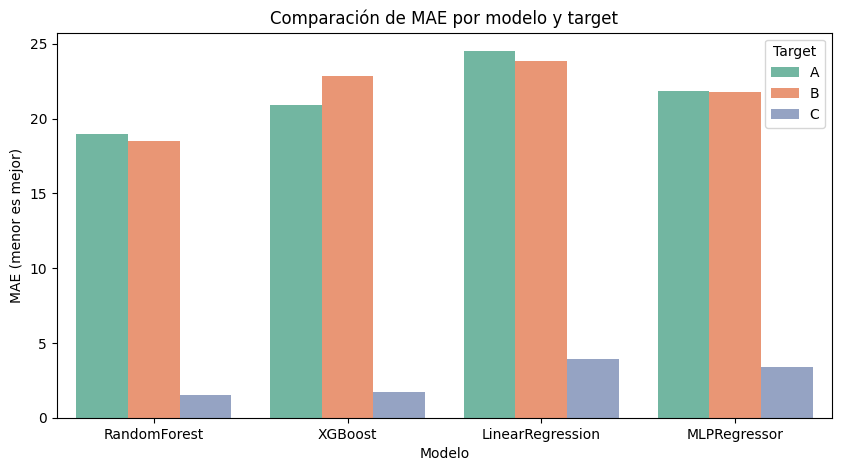

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(
    data=df_resultados,
    x="Modelo",
    y="MAE",
    hue="Target",
    palette="Set2"
)

plt.title("Comparación de MAE por modelo y target")
plt.ylabel("MAE (menor es mejor)")
plt.xlabel("Modelo")
plt.legend(title="Target")
plt.show()


## Comparación de R² por modelo y target

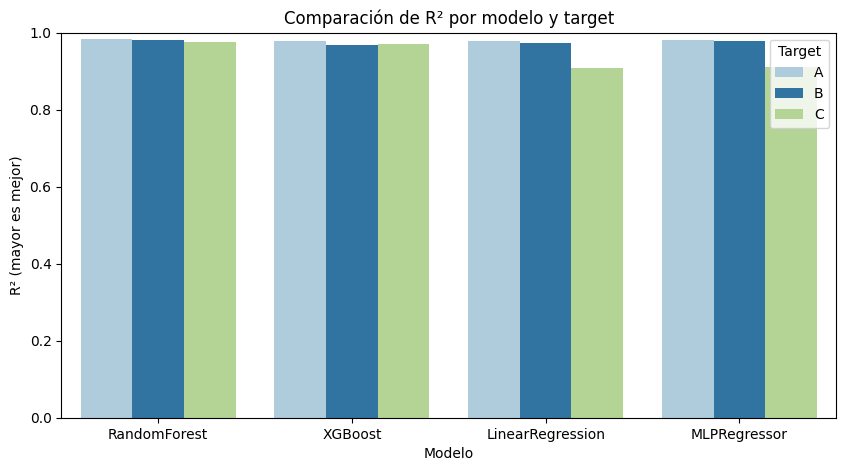

In [23]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=df_resultados,
    x="Modelo",
    y="R2",
    hue="Target",
    palette="Paired"
)

plt.title("Comparación de R² por modelo y target")
plt.ylabel("R² (mayor es mejor)")
plt.xlabel("Modelo")
plt.ylim(0, 1)
plt.legend(title="Target")
plt.show()


## Heatmap: Resumen visual general

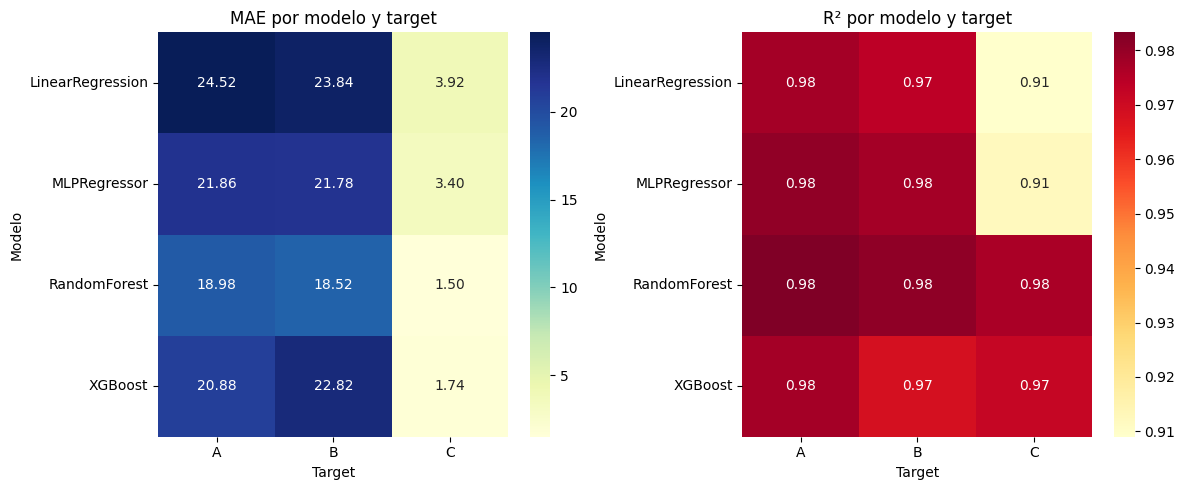

In [24]:
pivot_mae = df_resultados.pivot(index="Modelo", columns="Target", values="MAE")
pivot_r2 = df_resultados.pivot(index="Modelo", columns="Target", values="R2")

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(pivot_mae, annot=True, cmap="YlGnBu", fmt=".2f", ax=axes[0])
axes[0].set_title("MAE por modelo y target")

sns.heatmap(pivot_r2, annot=True, cmap="YlOrRd", fmt=".2f", ax=axes[1])
axes[1].set_title("R² por modelo y target")

plt.tight_layout()
plt.show()


## Curvas Predicción vs Real

In [29]:
!pip install plotly

import plotly.express as px

fig = px.bar(df_resultados, x="Modelo", y="R2", color="Target", barmode="group",
             title="Comparación de R² por Target (interactivo)")
fig.show()






## Crear una variable binaria: Alta ocupación y Demanda crítica

In [35]:
df["ocupacion_ratio"] = df["camas_ocupadas_total"] / (
    df["camas_habilitadas_planta"] + df["camas_habilitadas_uci"]
)

df["alta_ocupacion"] = (df["ocupacion_ratio"] > 0.8).astype(int)

# Ordenar por fecha y dividir temporalmente
df = df.sort_values("fecha")

train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print("Train:", train_df["fecha"].min(), "→", train_df["fecha"].max())
print("Test:", test_df["fecha"].min(), "→", test_df["fecha"].max())

Train: 2022-01-01 00:00:00 → 2022-01-28 00:00:00
Test: 2022-01-29 00:00:00 → 2022-02-04 00:00:00


## Entrenar modelos para clasificación

In [36]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc

modelos_clf = {
    "RandomForest": RandomForestClassifier(random_state=42, n_estimators=300),
    "XGBoost": XGBClassifier(random_state=42, n_estimators=300),
    "LogisticRegression": LogisticRegression(max_iter=500),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

X_train = train_df[features]
X_test = test_df[features]
y_train = train_df["alta_ocupacion"]
y_test = test_df["alta_ocupacion"]


## Curvas ROC comparativas

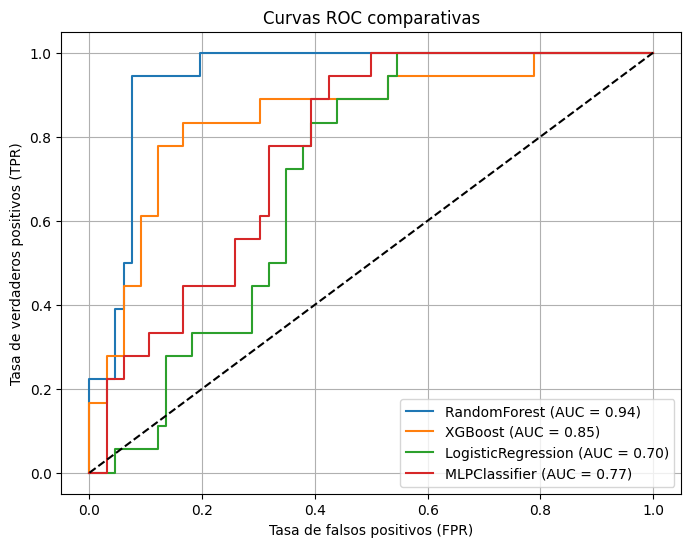

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for nombre, modelo in modelos_clf.items():
    modelo.fit(X_train, y_train)
    y_score = modelo.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curvas ROC comparativas")
plt.legend()
plt.grid(True)
plt.show()


## Curvas Precision–Recall comparativas

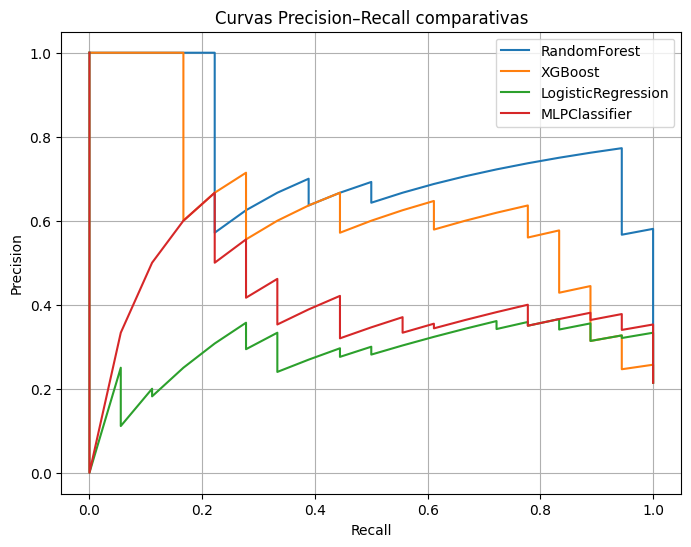

In [38]:
plt.figure(figsize=(8,6))

for nombre, modelo in modelos_clf.items():
    modelo.fit(X_train, y_train)
    y_score = modelo.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.plot(recall, precision, label=nombre)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision–Recall comparativas")
plt.legend()
plt.grid(True)
plt.show()


## Mejor Modelo

### Target, R2 y “ranking”

In [39]:
# Agregar ranking (1 = mejor)
df_resultados["rank_MAE"] = df_resultados.groupby("Target")["MAE"].rank(ascending=True)
df_resultados["rank_R2"] = df_resultados.groupby("Target")["R2"].rank(ascending=False)

# Puntaje combinado (menor = mejor)
df_resultados["score_global"] = df_resultados["rank_MAE"] + df_resultados["rank_R2"]

# Mostrar resumen
tabla_mejores = (
    df_resultados.sort_values(["Target", "score_global"])
    .groupby("Target")
    .first()
    .reset_index()
)

tabla_mejores


,Target,Modelo,MAE,R2,rank_MAE,rank_R2,score_global
0,A,RandomForest,18.975794,0.983318,1.0,1.0,2.0
1,B,RandomForest,18.517698,0.980908,1.0,1.0,2.0
2,C,RandomForest,1.496706,0.976691,1.0,1.0,2.0


### AUC-ROC, Average Precision (AP) y Accuracy

In [40]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

resultados_clf = []

for nombre, modelo in modelos_clf.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_score = modelo.predict_proba(X_test)[:, 1]

    auc_roc = roc_auc_score(y_test, y_score)
    ap = average_precision_score(y_test, y_score)
    acc = accuracy_score(y_test, y_pred)

    resultados_clf.append({
        "Modelo": nombre,
        "AUC_ROC": auc_roc,
        "Average_Precision": ap,
        "Accuracy": acc
    })

df_resultados_clf = pd.DataFrame(resultados_clf)
df_resultados_clf = df_resultados_clf.sort_values("AUC_ROC", ascending=False)
df_resultados_clf


,Modelo,AUC_ROC,Average_Precision,Accuracy
0,RandomForest,0.941077,0.763057,0.821429
1,XGBoost,0.851852,0.645383,0.809524
3,MLPClassifier,0.771886,0.423440,0.797619
2,LogisticRegression,0.703704,0.313048,0.738095


### Tabla final comparativa con ranking

In [41]:
df_resultados_clf["Rank_AUC"] = df_resultados_clf["AUC_ROC"].rank(ascending=False)
df_resultados_clf["Rank_AP"] = df_resultados_clf["Average_Precision"].rank(ascending=False)
df_resultados_clf["Rank_ACC"] = df_resultados_clf["Accuracy"].rank(ascending=False)

df_resultados_clf["Score_Global"] = (
    df_resultados_clf["Rank_AUC"] + df_resultados_clf["Rank_AP"] + df_resultados_clf["Rank_ACC"]
)

tabla_final = df_resultados_clf.sort_values("Score_Global")
tabla_final


,Modelo,AUC_ROC,Average_Precision,Accuracy,Rank_AUC,Rank_AP,Rank_ACC,Score_Global
0,RandomForest,0.941077,0.763057,0.821429,1.0,1.0,1.0,3.0
1,XGBoost,0.851852,0.645383,0.809524,2.0,2.0,2.0,6.0
3,MLPClassifier,0.771886,0.423440,0.797619,3.0,3.0,3.0,9.0
2,LogisticRegression,0.703704,0.313048,0.738095,4.0,4.0,4.0,12.0


In [42]:
mejor_modelo = tabla_final.iloc[0]["Modelo"]
print(f"🏆 Mejor modelo global: {mejor_modelo}")


🏆 Mejor modelo global: RandomForest


In [43]:
import plotly.express as px

fig = px.bar(
    df_resultados_clf.melt(id_vars="Modelo", value_vars=["AUC_ROC", "Average_Precision", "Accuracy"]),
    x="Modelo", y="value", color="variable", barmode="group",
    title="Comparación de métricas por modelo (clasificación)"
)
fig.show()


# Predicción del modelo elegido

MAE: 18.88
R²: 0.98


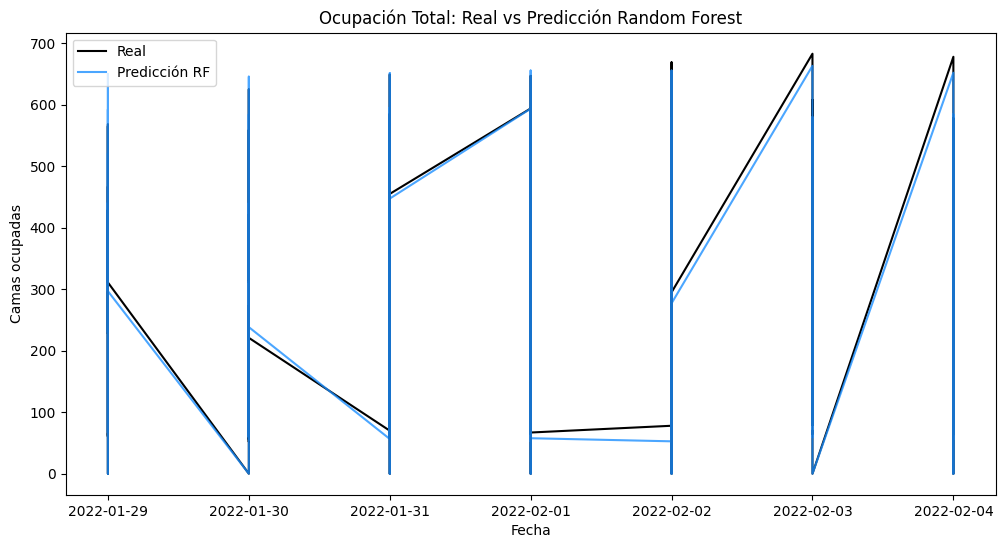

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Target que queremos predecir
target = "camas_ocupadas_total"

# Preparar datos
X_train = train_df[features]
X_test = test_df[features]
y_train = train_df[target]
y_test = test_df[target]

# Entrenar Random Forest
rf_model = RandomForestRegressor(random_state=42, n_estimators=300)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

# Métricas finales
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# Comparación real vs predicho
plt.figure(figsize=(12,6))
plt.plot(test_df["fecha"], y_test, label="Real", color="black")
plt.plot(test_df["fecha"], y_pred, label="Predicción RF", color="dodgerblue", alpha=0.8)
plt.title(f"Ocupación Total: Real vs Predicción Random Forest")
plt.xlabel("Fecha")
plt.ylabel("Camas ocupadas")
plt.legend()
plt.show()


In [45]:
# Crear DataFrame de predicciones
df_predicciones = test_df.copy()
df_predicciones["pred_camas_total"] = y_pred

# Seleccionar columnas relevantes
df_export = df_predicciones[[
    "provincia", "hospital", "fecha",
    "camas_ocupadas_total", "pred_camas_total",
    "camas_ocupadas_planta", "camas_ocupadas_uci"
]]

# Guardar en CSV
df_export.to_csv("predicciones_random_forest.csv", index=False)
print("✅ Predicciones guardadas en predicciones_random_forest.csv")

# Mostrar primeras filas
df_export.head()


✅ Predicciones guardadas en predicciones_random_forest.csv


,provincia,hospital,fecha,camas_ocupadas_total,pred_camas_total,camas_ocupadas_planta,camas_ocupadas_uci
86,Burgos,Hospital Santiago ApÃ³stol,2022-01-29,64.0,60.190000,64.0,0.0
255,Valladolid,Edificio Rondilla,2022-01-29,0.0,0.000000,0.0,0.0
252,Valladolid,Hospital Universitario RÃ­o Hortega,2022-01-29,429.0,440.766667,397.0,32.0
378,Segovia,Complejo Asistencial de Segovia,2022-01-29,228.0,229.423333,217.0,11.0
253,Valladolid,Hospital ClÃ­nico Universitario de Valladolid,2022-01-29,467.0,520.943333,427.0,40.0


In [46]:
from google.colab import files

# Guardar CSV
df_export.to_csv("predicciones_random_forest.csv", index=False)
print("✅ Archivo generado: predicciones_random_forest.csv")

# Descargar CSV
files.download("predicciones_random_forest.csv")


✅ Archivo generado: predicciones_random_forest.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>